In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.formula.api as smf

## download the dataset from:
 https://github.com/picniclin/NYC_yl5240/blob/master/geolytics_NYC_census_1990-2010.csv

or

https://drive.google.com/a/nyu.edu/file/d/0B2HY61hRpF-jV21KSTVsbi1wS3M/view?usp=sharing

# To measure the relationship between the change of housing rent price and entropy index of income_level groups

In [2]:
df = pd.read_csv('/Users/apple/Downloads/geolytics_NYC_census_1990-2010.csv')

In [3]:
df.shape

(2168, 146)

In [4]:
df.columns

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'TRCTPOP9', 'POVRAT9N',
       ...
       'THY01001A', 'THY01251A', 'THY01501A', 'THY02001A', 'THY0M201A',
       'MDHHY1A', 'MDVALHS1A', 'MCSMORT1A', 'MCSNMOR1A', 'MDGRENT1A'],
      dtype='object', length=146)

In [5]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,TRCTPOP9,POVRAT9N,...,THY01001A,THY01251A,THY01501A,THY02001A,THY0M201A,MDHHY1A,MDVALHS1A,MCSMORT1A,MCSNMOR1A,MDGRENT1A
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


## make the column names readable

In [6]:
cols = df.columns.str.replace('TRCTPOP', 'pop')\
            .str.replace('MDFAMY','median_inc_fam_')\
            .str.replace('FAVINC', 'ave_inc_fam_')\
            .str.replace('MDHHY', 'median_inc_hh_')\
            .str.replace('AVHHIN', 'ave_inc_hh_')\
            .str.replace('FALTY', 'fam_inc_')\
            .str.replace('FALT', 'fam_inc_')\
            .str.replace('MXB', 'max_')\
            .str.replace('FAY0', 'fam_inc_')\
            .str.replace('fam_inc_M', 'fam_inc_max_')\
            .str.replace('THY0', 'hh_inc_' )\
            .str.replace('hh_inc_M', 'hh_inc_max_')\
            .str.replace('MDVALHS','median_house_value_')\
            .str.replace('MDGRENT', 'median_rent_' )\
            .str.replace('MCSMORT', 'owner_cost_mo_' )\
            .str.replace('MCSNMOR', 'owner_cost_no_mo_' )\
            .str.replace('OCCHU', 'occ_')\
            .str.replace('VACHU', 'vacant_')\
            .str.replace('RNTOCC','renter_occ_')\
            .str.replace('OWNOCC', 'owner_occ_')\
            .str.replace('SPRNTOC', 'spec_renter_occ_')\
            .str.replace('SPOWNOC', 'spec_owner_occ_')\
            .str.replace('PRSOCU', 'person_occ_')\
            .str.replace('PRSOWNU', 'person_owner_occ_')\
            .str.replace('PRSRNTU', 'person_renter_occ_')\
            .str.replace('POVRAT','poverty')\
            .str.replace('1A', '1')\
            .str.replace('9A', '9')
            
cols

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [7]:
df.columns = cols

df.rename(columns = {'AREAKEY' : 'census_tract_id',
                     'STATE':'state','STUSAB':'abb.',
                     'TCH_90_10':'tract_change_90', 'TCH_00_10':'tract_change_00',
                    'INTPTLAT':'lat', 'INTPTLON':'lon',
                    'ZCTA5':'zip'}, inplace = True)
df.columns

Index(['census_tract_id', 'state', 'abb.', 'lat', 'lon', 'tract_change_90',
       'tract_change_00', 'zip', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [8]:
df = df.dropna()
df.zip = df.zip.astype('int')
df.shape

(2157, 146)

In [9]:
## delete the observation, i.e. census tract, with 0 median rent or 0 median families income
df = df[~((df.median_rent_0 == 0)| (df.median_rent_9 == 0)|(df.median_rent_1 == 0)|\
         (df.median_inc_fam_9 == 0)| (df.median_inc_fam_9 == 0)|(df.median_inc_fam_1 == 0))]

In [10]:
df.shape

(2089, 146)

In [11]:
df.head()

,census_tract_id,state,abb.,lat,lon,tract_change_90,tract_change_00,zip,pop9,poverty9N,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454,1575,797,...,14,19,21,0,0,25093,0,0,539,870
5,36005002000,36,NY,40.817580,-73.866096,0,0,10473,9110,3423,...,180,161,0,45,12,24939,398100,2185,715,455


## split the dataset into several sub-tables

In [12]:
# the sub-table of census tract information, including geoid, latitude, longitude, and zip.
df_tract = df.iloc[:, [0,3,4,7]]
df_tract.head()

,census_tract_id,lat,lon,zip
1,36005000200,40.804573,-73.856859,10473
2,36005000400,40.808915,-73.850488,10473
3,36005001600,40.818848,-73.858076,10473
4,36005001900,40.800999,-73.909373,10454
5,36005002000,40.817580,-73.866096,10473


In [13]:
# the sub-table of different groups of families income level
df_family_income = df.loc[:,df.columns[df.columns.str.startswith('fam_inc_')]]
df_family_income_1990 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('9')]]
df_family_income_2000 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('0')]]
df_family_income_2010 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('1')]]

 
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 14), (2089, 16), (2089, 16))

In [14]:
df_1990 = df.iloc[:, 8:42]
df_2000 = df.iloc[:, 42:94]
df_2010 = df.iloc[:, 94:]
df_1990.shape, df_2000.shape, df_2010.shape

((2089, 34), (2089, 52), (2089, 52))

In [15]:
# the sub-table of housing price and rent
df_house = df.loc[:,df.columns[(df.columns.str.startswith('median_rent_')) |\
                              (df.columns.str.startswith('median_house_'))]]
df_house.head()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
1,136500,742,147500,730,392500,1273
2,163234,535,157610,643,393700,1330
3,156800,466,177000,558,378100,823
4,48868,422,145960,461,0,870
5,185400,298,177600,266,398100,455


In [16]:
df_house.describe()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
count,2089.000000,2089.000000,2.089000e+03,2089.000000,2.089000e+03,2089.000000
mean,170909.090953,544.198181,2.233565e+05,753.071326,5.070657e+05,1151.020105
std,110359.984751,150.069074,1.826276e+05,231.835763,2.214706e+05,331.293631
min,0.000000,140.000000,0.000000e+00,175.000000,0.000000e+00,231.000000
25%,118204.000000,453.000000,1.604000e+05,644.000000,3.981000e+05,964.000000
50%,171500.000000,531.000000,1.964000e+05,740.000000,4.941000e+05,1120.000000
75%,218689.000000,629.000000,2.508000e+05,834.000000,6.275000e+05,1308.000000
max,500001.000000,1001.000000,1.000001e+06,2001.000000,1.000001e+06,2001.000000


In [17]:
# the sub-table of median/average families/households income
df_income = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_')) |\
                              (df.columns.str.startswith('ave_inc_'))]]
df_income.head()   

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
1,45267.28710,38711,41034.78595,31632,50763.54348,50817,48547.32784,42539,67363.981,58368,66324.981,59826
2,43694.20068,40484,41850.02374,36506,48306.41829,41019,45697.79035,39111,86056.373,73148,82305.160,71968
3,30042.84776,24732,27803.12012,22739,36442.53563,30104,31610.56070,24552,43473.490,33555,38629.904,30355
4,23377.47813,24823,19303.58696,11215,31360.47431,23671,27995.65217,22772,35995.455,25489,33907.328,25093
5,25062.06250,18762,22262.06940,14765,26817.80645,19694,24885.52589,14691,41842.527,30817,35687.455,24939


In [18]:
df_income.describe()

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.00000,2089.000000,2089.000000,2089.000000
mean,46240.797301,37689.401628,39246.703235,31309.411202,63576.869583,48874.026807,54229.582025,40628.821446,85376.28443,66207.958353,72345.813173,54703.689325
std,28606.446820,18760.425689,19565.189172,13562.873547,45058.370638,28645.098401,29038.210224,18527.299709,62564.07724,39910.826453,40603.704702,25923.948148
min,0.000000,86.000000,0.000000,5360.000000,16376.090910,7354.000000,12747.077320,7863.000000,0.00000,8542.000000,0.000000,8694.000000
25%,30501.042240,24924.000000,27864.930300,21862.000000,40513.116200,30724.000000,37683.585970,27976.000000,52010.32700,40022.000000,48876.596000,36299.000000
50%,41866.927540,36218.000000,36208.754250,30417.000000,53041.525420,42590.000000,48376.129030,37936.000000,70564.74300,56726.000000,64120.604000,51127.000000
75%,53084.721130,46843.000000,46187.374640,39697.000000,69321.465430,58977.000000,62046.691640,50806.000000,93098.66200,80125.000000,82035.096000,68026.000000
max,327320.474100,150001.000000,248923.005700,147567.000000,450967.828700,200001.000000,337238.297900,174119.000000,636204.42600,250001.000000,464390.618000,232768.000000


## create the table for relationship analysis
To compare the 1990 data, we choose the family income, not household income.


The variables we need are median family income, median rent, families with different income level

In [19]:
df_1 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) |\
                                (df.columns.str.startswith('fam_inc_'))]]

In [20]:
df_1.shape

(2089, 52)

In [21]:
df_1.columns

Index(['median_inc_fam_9', 'fam_inc_109', 'fam_inc_159', 'fam_inc_209',
       'fam_inc_259', 'fam_inc_309', 'fam_inc_359', 'fam_inc_409',
       'fam_inc_499', 'fam_inc_609', 'fam_inc_759', 'fam_inc_1009',
       'fam_inc_1259', 'fam_inc_1509', 'fam_inc_max_9', 'median_rent_9',
       'median_inc_fam_0', 'fam_inc_100', 'fam_inc_150', 'fam_inc_200',
       'fam_inc_250', 'fam_inc_300', 'fam_inc_350', 'fam_inc_400',
       'fam_inc_450', 'fam_inc_500', 'fam_inc_600', 'fam_inc_750',
       'fam_inc_1000', 'fam_inc_1250', 'fam_inc_1500', 'fam_inc_2000',
       'fam_inc_max_200', 'median_rent_0', 'median_inc_fam_1', 'fam_inc_101',
       'fam_inc_151', 'fam_inc_201', 'fam_inc_251', 'fam_inc_301',
       'fam_inc_351', 'fam_inc_401', 'fam_inc_451', 'fam_inc_501',
       'fam_inc_601', 'fam_inc_751', 'fam_inc_1001', 'fam_inc_1251',
       'fam_inc_1501', 'fam_inc_2001', 'fam_inc_max_201', 'median_rent_1'],
      dtype='object')

In [22]:
df2 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) ]]

In [23]:
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1
1,38711,742,50817,730,58368,1273
2,40484,535,41019,643,73148,1330
3,24732,466,30104,558,33555,823
4,24823,422,23671,461,25489,870
5,18762,298,19694,266,30817,455


# Calculate entropy index of different income-level groups for each census tract from 1990 to 2010

In [24]:
# define entropy index 
def entropy_index(x):
    Q_sum = 0
    for i in x:
        if i == 0:
            Q = 0
        else:
            Q = (-1) * (i/sum(x)) * np.log(i/sum(x))
        Q_sum += Q
    entropy_index = Q_sum/np.log(len(x))
    return entropy_index

In [25]:
# have a try
entropy_index(list(df_family_income_1990.iloc[0,:]))

0.92246865765414721

In [26]:
# calculate the entropy index of 1990
for i in df_family_income_1990.index:
    df_family_income_1990.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_1990.loc[i,:'fam_inc_max_9']))

In [27]:
df_family_income_1990.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9,entropy_index
1,29,29,12,31,20,32,31,84,75,59,68,35,18,2,0.922469
2,19,17,11,34,1,50,50,89,71,58,62,28,1,1,0.863543
3,142,28,124,84,41,165,39,161,69,70,45,11,0,0,0.863912
4,50,39,0,0,3,0,0,67,26,10,0,0,0,0,0.577145
5,284,201,107,60,74,131,95,203,158,40,84,8,0,13,0.875156


In [28]:
# calculate the entropy index of 2000 and 2010
for i in df_family_income_2000.index:
    df_family_income_2000.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2000.loc[i,:'fam_inc_max_200']))

for i in df_family_income_2010.index:
    df_family_income_2010.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2010.loc[i,:'fam_inc_max_201']))

In [29]:
# merge the entropy index data into df2
df2['entropy_index_9'] = df_family_income_1990.iloc[:,-1]
df2['entropy_index_0'] = df_family_income_2000.iloc[:,-1]
df2['entropy_index_1'] = df_family_income_2010.iloc[:,-1]
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,entropy_index_9,entropy_index_0,entropy_index_1
1,38711,742,50817,730,58368,1273,0.922469,0.871427,0.894048
2,40484,535,41019,643,73148,1330,0.863543,0.914607,0.898725
3,24732,466,30104,558,33555,823,0.863912,0.902281,0.894488
4,24823,422,23671,461,25489,870,0.577145,0.825729,0.842364
5,18762,298,19694,266,30817,455,0.875156,0.795292,0.918302


In [30]:
df2.shape

(2089, 9)

In [31]:
sum(np.array(df2 == 0))

array([0, 0, 0, 0, 0, 0, 8, 2, 1])

In [32]:
## drop the 0 values of entropy index
df2_1 = df2[~((df2.entropy_index_9 == 0)|(df2.entropy_index_0 == 0)|(df2.entropy_index_1 == 0))]
df2_1.shape

(2080, 9)

## Calculate the change of rent and entropy index of 1990-2000 and 2000-2010

In [33]:
df3 = pd.DataFrame()
df3['median_rent_growth_90_00'] = df2_1.median_rent_0/df2_1.median_rent_9
df3['median_rent_growth_00_10'] = df2_1.median_rent_1/df2_1.median_rent_0
df3['entropy_index_change_90_00'] = df2_1.entropy_index_0/df2_1.entropy_index_9
df3['entropy_index_change_00_10'] = df2_1.entropy_index_1/df2_1.entropy_index_0
df3['median_fam_inc_growth_90_00'] = df2_1.median_inc_fam_0/df2_1.median_inc_fam_9
df3['median_fam_inc_growth_00_10'] = df2_1.median_inc_fam_1/df2_1.median_inc_fam_0
df3.head()

,median_rent_growth_90_00,median_rent_growth_00_10,entropy_index_change_90_00,entropy_index_change_00_10,median_fam_inc_growth_90_00,median_fam_inc_growth_00_10
1,0.983827,1.743836,0.944669,1.025959,1.312728,1.148592
2,1.201869,2.068429,1.059133,0.982635,1.013215,1.783271
3,1.197425,1.474910,1.044414,0.991363,1.217208,1.114636
4,1.092417,1.887202,1.430712,1.020146,0.953591,1.076803
5,0.892617,1.710526,0.908743,1.154674,1.049675,1.564791


In [34]:
df3.describe()

,median_rent_growth_90_00,median_rent_growth_00_10,entropy_index_change_90_00,entropy_index_change_00_10,median_fam_inc_growth_90_00,median_fam_inc_growth_00_10
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,1.393492,1.550774,1.056854,0.954204,1.304846,1.386766
std,0.235155,0.264145,0.130683,0.093989,0.366783,0.367756
min,0.624286,0.326599,0.617491,0.283982,0.536671,0.210854
25%,1.272691,1.412871,1.007665,0.909084,1.100241,1.156685
50%,1.378611,1.526301,1.044176,0.964268,1.248453,1.336644
75%,1.485551,1.655776,1.085437,1.009554,1.421796,1.546234
max,4.547727,4.600000,4.258258,1.296619,8.984771,4.714033


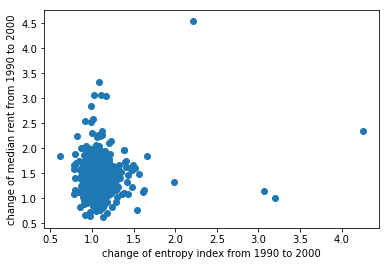

In [35]:
plt.scatter(df3.entropy_index_change_90_00, df3.median_rent_growth_90_00)
plt.xlabel('change of entropy index from 1990 to 2000')
plt.ylabel('change of median rent from 1990 to 2000')

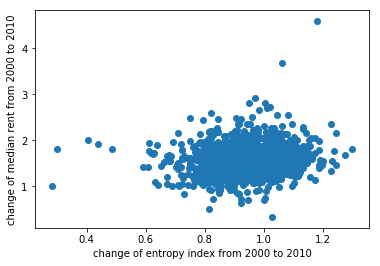

In [36]:
plt.scatter(df3.entropy_index_change_00_10, df3.median_rent_growth_00_10)
plt.xlabel('change of entropy index from 2000 to 2010')
plt.ylabel('change of median rent from 2000 to 2010')

In [41]:
lm1 = smf.ols('median_rent_growth_90_00 ~ entropy_index_change_90_00', df3).fit()
lm2 = smf.ols('median_rent_growth_00_10 ~ entropy_index_change_00_10', df3).fit()

In [42]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     median_rent_growth_90_00   R-squared:                       0.002
Model:                                  OLS   Adj. R-squared:                  0.002
Method:                       Least Squares   F-statistic:                     5.164
Date:                      Mon, 06 Nov 2017   Prob (F-statistic):             0.0232
Time:                              02:22:03   Log-Likelihood:                 62.507
No. Observations:                      2080   AIC:                            -121.0
Df Residuals:                          2078   BIC:                            -109.7
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      1.2988      0.042     30.936      0.000         1.216     1.381
entropy_index_change_90_00     0.0896      0.039      2.273      0.023         0.012     0.167
==============================================================================
Omnibus:                     1287.517   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40258.993
Skew:                           2.390   Prob(JB):                         0.00
Kurtosis:                      24.016   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     median_rent_growth_00_10   R-squared:                       0.012
Model:                                  OLS   Adj. R-squared:                  0.012
Method:                       Least Squares   F-statistic:                     25.58
Date:                      Mon, 06 Nov 2017   Prob (F-statistic):           4.62e-07
Time:                              02:22:13   Log-Likelihood:                -169.15
No. Observations:                      2080   AIC:                             342.3
Df Residuals:                          2078   BIC:                             353.6
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      1.2551      0.059     21.362      0.000         1.140     1.370
entropy_index_change_00_10     0.3099      0.061      5.058      0.000         0.190     0.430
==============================================================================
Omnibus:                      882.613   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13449.507
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                      15.047   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# It seems that there is little linear relationship between change of income intergration and change of rent. 